# Assignment 3: ICP + Non-linear least squares optimization

TEAM-ID:   
TEAM-NAME:   
YOUR-ID:   
YOUR-NAME:   

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)


## Instructions

* Please check Moodle for "TEAM-ID" and "TEAM-NAME" fields above. Some of your names have been edited because of redundancy/simplicity. Instructions for submitting the assignment through GitHub Classrooms/Moodle has been uploaded on Moodle. Any clarifications will be made there itself.
* Code must be written in Python in Jupyter Notebooks. You can use Assignment-1's environment for this assignment. More instructions for setup provided as you progress through this assignment.
* Both the team members must submit the zip file.
* You are not allowed to use any external libraries (other than ones being imported below).
* Answer the descriptive questions in your own words with context & clarity. Do not just copy-paste from some Wikipedia page. You will be evaluated accordingly.
* You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.

In [68]:
# Only allowed to use these libraries for this assignment. 
# Setup: Just activate Assignment-1's environment and install matplotlib `python -m pip install -U matplotlib`

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

plt.style.use('seaborn-pastel')
mpl.rcParams['figure.dpi'] = 110

# Question 1: Simple Non-Linear least squares for Gaussian function

First, go through the [solved example here](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-13cf17d318be4d45bb8577c4d3ea4a02#1de60a8465664d39a12af24353feef9e) from the [notes page](https://www.notion.so/saishubodh/Mobile-Robotics-2020-Students-Page-0b65a9c20edd4081978f4ffad917febb#a68cabac64754fa485144cc89b4b8c65). After understanding this, 

(1.1) Code it from scratch using `numpy` and try it out yourself for say different number of iterations with a certain tolerance for all 50 observations using Gradient Descent. Make the following plots using `matplotlib`:
   * Data and fit plot: Ground truth Gaussian, observations (points) & predicted Gaussian on the same plot.
   * Cost function ($\|r\|^2$) vs number of iterations   
   
Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

(1.2) You've used Gradient Descent above. Now implement Gauss-Newton and LM algorithms. To contrast between the three, you must experiment with 
   * Different initial estimate: Can a particular algorithm handle if the initial estimate is too far from GT?
   * Different number of observations: Can a particular algorithm handle very less observations?
   * Add [noise](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) to your observations: Can a particular algorithm handle large noise?
   * What else can you think of? (For example, can an algorithm converge in less iterations compared to others?)
    
Make the plots (mentioned in 1.1) for all 3 algorithms. Report your observations in a table(s) (comparison between the three for different factors). You will be awarded depending on how comprehensive your experimentation is (which you have to explain below under "**Answers for Question 1**" section).

## Code for Question 1

In [90]:
# Only numpy & matplotlib is sufficient for this question.
##############################################################################
# TODO: Do tasks described in Question 1                                     #
##############################################################################

# CONSTANTS

# Ground Truth
ACTUAL_AMP = 10
ACTUAL_MEAN = 0
ACTUAL_SD = 20

# Data Generation
NUM_OBS = 50
X_RANGE = (-25, 25)
NOISE_MEAN = 0
NOISE_VAR = 1

# Hyperparameters
LEARN_RATE = 0.01
NUM_ITERS = 100
TOL = 1e-5

# Initialization
INIT_AMP = 10
INIT_MEAN = 13
INIT_SD = 19.12

# Utility
PLOT_RANGE = (-50, 50)
FIG_SIZE = (10, 4)

In [91]:
# UTILITY FUNCTIONS

def gaussian(amp, mu, sigma, x):
    return amp * np.exp(-((x - mu) ** 2)/(2 * (sigma ** 2)))

def generate_data(amp, mu, sigma, x_range, num_obs, noise=False, noise_mean=0, noise_var=1):
    x = np.linspace(*x_range, num_obs)
    y = gaussian(amp, mu, sigma, x)
    
    if noise:
        y += np.random.normal(noise_mean, noise_var, y.shape)
        
    return x, y

def plot_gaussian(plot, amp, mu, sigma, x_range=PLOT_RANGE, color=None, legend=None):
    '''generates its own datapoints to create the plot'''
    x, y = generate_data(amp, mu, sigma, x_range, 100)
    plot.plot(x, y, color=color, label=legend)

def plot_points(plot, x, y, color=None, legend=None):
    plot.scatter(x, y, marker='o', color=color, alpha=0.4, label=legend)

In [92]:
# ACTUAL STUFF

def residual(amp, mu, sigma, x, y):
    return gaussian(amp, mu, sigma, x) - y

def error(amp, mu, sigma, x, y):
    return np.linalg.norm(residual(amp, mu, sigma, x, y)) ** 2

def jacobian(amp, mu, sigma, x):
    exp = gaussian(1, mu, sigma, x)
    return np.c_[exp, amp * (x - mu) * exp / (sigma ** 2), amp * ((x - mu) ** 2) * exp / (sigma ** 3)]

def step_gd(amp, mu, sigma, x, y, alpha):
    J = jacobian(amp, mu, sigma, x)
    r = residual(amp, mu, sigma, x, y)
    return -alpha * (J.T @ r)

In [93]:
def gradient_descent(amp_0, mu_0, sigma_0, x, y, alpha=LEARN_RATE, num_iters=NUM_ITERS, tol=TOL):
    params = np.array([amp_0, mu_0, sigma_0], dtype=np.double)
    errors = [error(*params, x, y), ]
    
    for _ in range(num_iters):
        new_params = params + step_gd(*params, x, y, alpha)
        errors.append(error(*new_params, x, y))
        
        if np.linalg.norm(new_params - params) < tol:
            params = new_params
            break
            
        params = new_params
        
    return new_params, errors
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

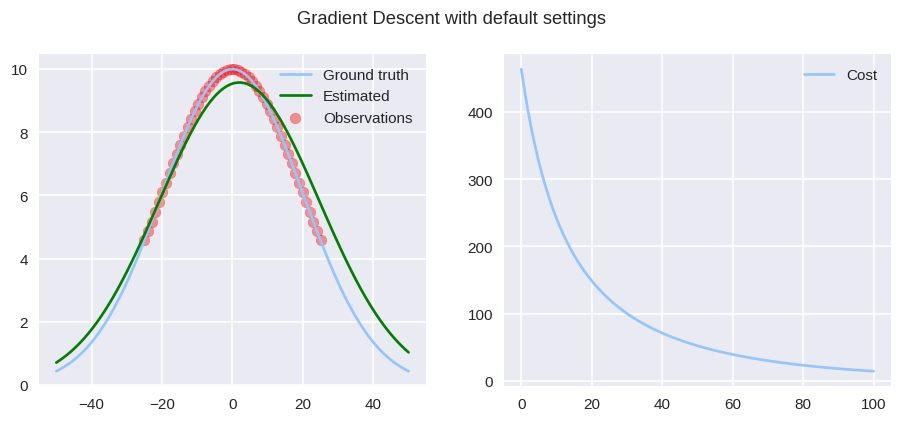

In [94]:
# Define the plots inside a function above and call them in this cell one by
# one. When I run this cell, all plots asked in Q1 should be generated. 
##############################################################################
# TODO: Plotting for Question 1                                              #
##############################################################################

# BASIC ALGORITHM RUNS

# Gradient Descent
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)
est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, INIT_SD, x, y)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with default settings')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, legend='Ground truth')
plot_gaussian(axl, *est_params, color='green', legend='Estimated')
plot_points(axl, x, y, color='red', legend='Observations')
axl.legend(loc='upper right')

axr.plot(errors, label='Cost')
axr.legend(loc='upper right')

plt.show()

# Gauss Newton
# Levenberg Marquadt

# COMPARISON RUNS

# Gradient Descent
# Gauss Newton
# Levenberg Marquadt
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Answers for Question 1
Add explanations for the answers along with tables here.
### Answer for 1.1
Explain your experimentations with justification here

| This          | is            | sample  |table   |
| ------------- |:-------------:| -------:|-------:|
| sample 1      | sample 1      | sample 1|sample 1|

### Answer for 1.2
Explain your experimentations with justification here

| This          | is            | sample  |table   |
| ------------- |:-------------:| -------:|-------:|
| sample 2      | sample 2      | sample 2|sample 2|



# Question 2: ICP Coding
Implement basic ICP algorithm with (given) known correspondences. 

Let X be your point cloud observed from the initial position. Your robot moved and observed P1 as your current point cloud. Same with P2 under a different transformation. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). Use *root mean squared error (rmse)* as the error metric.

In [ ]:
# HELPER FUNCTIONS: DON'T EDIT THIS BLOCK - If you want to test on more cases, you can add code to this block but
# DON'T delete existing code.


# Visualizing ICP registration
def plot_icp(X, P, P0, i, rmse):
  plt.cla()
  plt.scatter(X[0,:], X[1,:], c='k', marker='o', s=50, lw=0)
  plt.scatter(P[0,:], P[1,:], c='r', marker='o', s=50, lw=0)
  plt.scatter(P0[0,:], P0[1,:], c='b', marker='o', s=50, lw=0)
  plt.legend(('X', 'P', 'P0'), loc='lower left')
  plt.plot(np.vstack((X[0,:], P[0,:])), np.vstack((X[1,:], P[1,:])) ,c='k')
  plt.title("Iteration: " + str(i) + "  RMSE: " + str(rmse))
  plt.axis([-10, 15, -10, 15])
  plt.gca().set_aspect('equal', adjustable='box')
  plt.draw()
  plt.pause(2)
  return

# Generating data for our simple ICP
def generate_data():
  
  # create reference data  
  X = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,-1,-2,-3,-4,-5]])
  
  # add noise
  P = X + 0.05 * np.random.normal(0, 1, X.shape)
  
  # translate
  P[0,:] = P[0,:] + 1
  P[1,:] = P[1,:] + 1
  
  # rotate
  theta1 = ( 10.0 / 360) * 2 * np.pi
  theta2 = (110.0 / 360) * 2 * np.pi
  rot1 = np.array([[math.cos(theta1), -math.sin(theta1)],
                   [math.sin(theta1),  math.cos(theta1)]])
  rot2 = np.array([[math.cos(theta2), -math.sin(theta2)],
                   [math.sin(theta2),  math.cos(theta2)]])
  
  # sets with known correspondences
  P1 = np.dot(rot1, P)
  P2 = np.dot(rot2, P)
  
  return X, P1, P2

In [ ]:
# TODO: Do tasks described in Q2                                             #
##############################################################################
# Replace "pass" statement with your code

# TODO1: Get data X, P1, P2 from helper function generate_data(). 
pass

# TODO2: Apply ICP between X and P_i. (in our case,(X & P1) and (X & P2))
def ICP(X, P):
    num_iter = 5 #Experiment & check if your theoretical understanding is correct.
    P0 = P #Initialization
    for i in range(num_iter):
        # implementing ICP:

        # TODO2.1: what's current error?
        # TODO2.2: call visualization helper function plot_icp.
        # TODO2.3: Implement ICP to get R, t
        pass
        #P = np.dot(R, P) + t #Uncomment this: transforming my current point cloud towards initial point cloud

    return
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [ ]:
# Call ICP on P1 & P2

#ICP(X,P1) #Uncomment this
#ICP(X,P2) #Uncomment this